# Processed Data Visualization Notebook

In [186]:
%matplotlib inline
import h5py
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import re

## Open Processed Simulation Output

In [187]:
h5f = h5py.File("../data/processed/proc_sims_v5.h5", "r")

## Data Structure

In [188]:
print("Top-Level:\n", list(h5f.keys()))
print("Header:\n", list(h5f["sims"]))
print("sim<n>:\n", list(h5f["sims"]["sim0"]))
print("cl:\n", list(h5f["sims"]["sim0"]["cl"]))

Top-Level:
 ['sims']
Header:
 ['sim0', 'sim1', 'sim10', 'sim11', 'sim12', 'sim13', 'sim14', 'sim15', 'sim16', 'sim17', 'sim18', 'sim19', 'sim2', 'sim20', 'sim21', 'sim22', 'sim23', 'sim24', 'sim25', 'sim26', 'sim27', 'sim28', 'sim29', 'sim3', 'sim30', 'sim31', 'sim32', 'sim33', 'sim34', 'sim35', 'sim36', 'sim37', 'sim38', 'sim39', 'sim4', 'sim40', 'sim41', 'sim42', 'sim43', 'sim44', 'sim45', 'sim46', 'sim47', 'sim48', 'sim49', 'sim5', 'sim50', 'sim51', 'sim52', 'sim53', 'sim54', 'sim55', 'sim56', 'sim57', 'sim58', 'sim59', 'sim6', 'sim60', 'sim61', 'sim62', 'sim63', 'sim64', 'sim65', 'sim66', 'sim67', 'sim68', 'sim69', 'sim7', 'sim70', 'sim71', 'sim72', 'sim73', 'sim74', 'sim75', 'sim76', 'sim77', 'sim78', 'sim79', 'sim8', 'sim80', 'sim81', 'sim82', 'sim83', 'sim84', 'sim85', 'sim86', 'sim87', 'sim88', 'sim89', 'sim9', 'sim90', 'sim91', 'sim92', 'sim93', 'sim94', 'sim95', 'sim96', 'sim97', 'sim98', 'sim99']
sim<n>:
 ['alpha_zre', 'b0_zre', 'cl', 'kb_zre', 'ksz_map', 'pk_tt', 'tau', 'xm

## Build DataFrame

In [189]:
rows = []
sims = h5f["sims"]

# Iterate through all sims in sims/
for name in sorted(sims.keys(), key=lambda s: int(s[3:]) if s.startswith("sim") and s[3:].isdigit() else s):
    g = sims[name]
    rows.append({
        "sim":          name,
        # Parameters
        "alpha_zre":    float(g["alpha_zre"][()]),
        "kb_zre":       float(g["kb_zre"][()]),
        "zmean_zre":    float(g["zmean_zre"][()]),
        "b0_zre":       float(g["b0_zre"][()]),
        "tau":          float(g["tau"][()]),
        # Info about per-sim grids
        "n_z":          int(g["zval_list"].shape[0]),
        "n_xm":         int(g["xmval_list"].shape[0]),
    })

df = pd.DataFrame(rows)
df.head()

,sim,alpha_zre,kb_zre,zmean_zre,b0_zre,tau,n_z,n_xm
0,sim0,0.123569,0.361813,8.026353,0.59312,0.061644,26,26
1,sim1,0.658593,1.319570,8.276313,0.59312,0.063535,26,26
2,sim2,0.569787,0.369425,8.481533,0.59312,0.064694,26,26
3,sim3,0.151896,1.349346,8.802202,0.59312,0.069647,26,26
4,sim4,0.194290,1.111912,7.723515,0.59312,0.058893,26,26


## Simulation Parameters
- **`alpha`** (0.10 - 0.90) : Controls how long reionization lasts.
- **`kb`** (0.10 - 2.0) : Determines how uneven the ionized regions are (higher values more clustered).
- **`zmean`** (7.0 - 9.0) : Sets the midpoint of reionization.
- **`b0`** (? - ?) : Adjusts the overall strength or amplitude of the ionization field.

### Summary

In [190]:
def summarize(col):
    s = df[col]
    return {"min": s.min(), "max": s.max(), "mean": s.mean(), "std": s.std(ddof=1), "n_unique": s.nunique()}

summary = pd.DataFrame({c: summarize(c) for c in ["alpha_zre","kb_zre","zmean_zre", "b0_zre"]}).T
summary


,min,max,mean,std,n_unique
alpha_zre,0.106138,0.892581,0.500387,2.320735e-01,100.0
kb_zre,0.104399,1.987047,1.050257,5.515132e-01,100.0
zmean_zre,7.013623,8.984811,7.999837,5.803226e-01,100.0
b0_zre,0.593120,0.593120,0.593120,2.231632e-16,1.0


### Histogram of Parameter Space
- Histograms should be flat for uniform coverage.

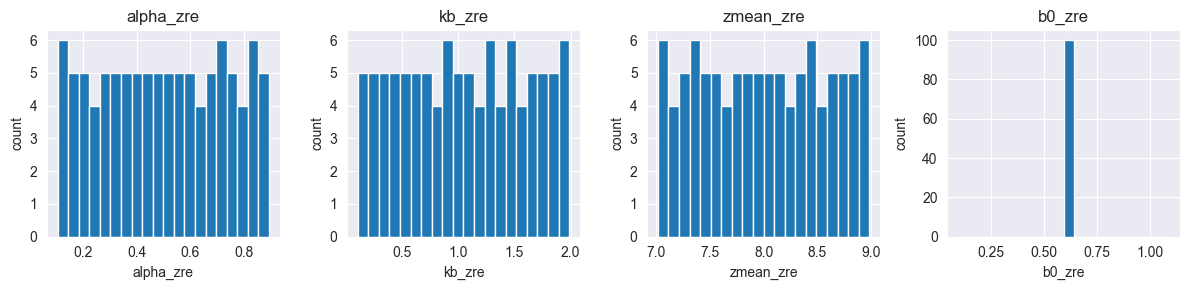

In [191]:
plt.figure(figsize=(12,3))
for i, col in enumerate(["alpha_zre","kb_zre","zmean_zre", "b0_zre"], 1):
    plt.subplot(1,4,i)
    plt.hist(df[col], bins=20)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("count")
plt.tight_layout()
plt.show()

plt.show()


### Spearman Correlation (Independence)
- Measure how monotonic the relationship is between pairs or parameters.
- +1.0 : Perfect increasing monotonic relation
- -1.0 : Perfect decreasing relation
-  0.0 : No Monotonic relation

In [192]:
df[["alpha_zre","kb_zre","zmean_zre"]].corr(method="spearman")


,alpha_zre,kb_zre,zmean_zre
alpha_zre,1.000000,-0.14345,0.054917
kb_zre,-0.143450,1.00000,-0.138830
zmean_zre,0.054917,-0.13883,1.000000


### Coverage of Parameter Space
- `Min Pairwise Distance`: THe smallest distance between any two parameters.
- `Median Pairwise Distance`: The median distance among all pairs of parameters.
- `Distribution of Pairwise Distances`: Visualize the distribution of distances.

Min Pairwise Distance: 0.026
Median Pairwise Distance: 0.675


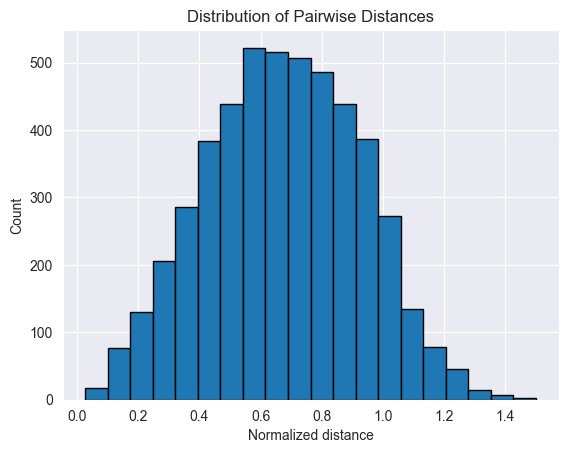

In [193]:
X = df[["alpha_zre","kb_zre","zmean_zre"]].to_numpy()
# Normalize to [0,1]
Xn = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
D = pdist(Xn)

print(f"Min Pairwise Distance: {np.min(D):.3f}")
print(f"Median Pairwise Distance: {np.median(D):.3f}")

plt.figure()
plt.hist(D, bins=20, edgecolor='black')
plt.title("Distribution of Pairwise Distances")
plt.xlabel("Normalized distance")
plt.ylabel("Count")
plt.show()

## Simulation Output
- **`tau`** — The optical depth to reionization; measures how many CMB photons were scattered by free electrons.
- **`xmval_list`** — The average ionized fraction of the universe at different times; shows how reionization progressed.
- **`zval_list`** — The redshift values that correspond to each point in the ionization history.
- **`ksz_map`** — A 2D map of temperature fluctuations caused by the kinematic Sunyaev–Zel’dovich effect.
- **`pk_tt`** —

### Check for Invalid or Empty Output

In [194]:
def sim_order(s):
    m = re.match(r"sim(\d+)$", s)
    return int(m.group(1)) if m else 10**9

bad = []
for s in sorted(h5f["sims"].keys(), key=sim_order):
    g = h5f["sims"][s]
    pk = g["pk_tt"][()]
    kz = g["ksz_map"][()]
    if pk.size == 0 or kz.size == 0 or np.any(~np.isfinite(pk)) or np.any(~np.isfinite(kz)):
        bad.append(s)
bad

[]

### kSZ Map Mean/STD Distribution

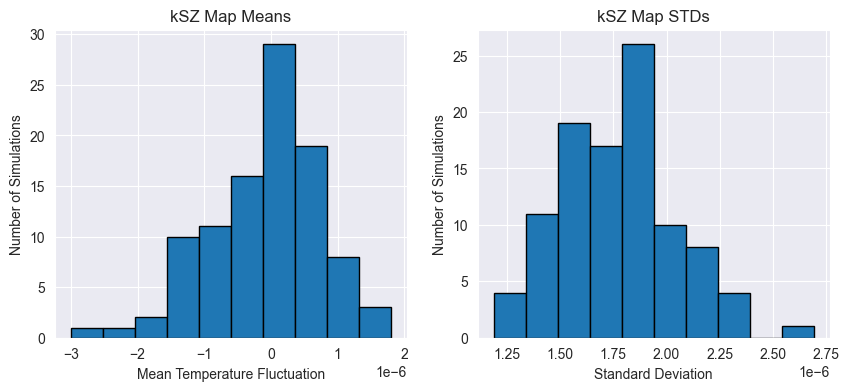

In [195]:
means, stds = [], []
for s in h5f["sims"].keys():
    m = h5f["sims"][s]["ksz_map"][()]
    means.append(float(np.mean(m)))
    stds.append(float(np.std(m)))

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot histogram for means
axes[0].hist(means, bins=10, edgecolor='black')
axes[0].set_title("kSZ Map Means")
axes[0].set_xlabel("Mean Temperature Fluctuation")
axes[0].set_ylabel("Number of Simulations")

# Plot histogram for stds
axes[1].hist(stds, bins=10, edgecolor='black')
axes[1].set_title("kSZ Map STDs")
axes[1].set_xlabel("Standard Deviation")
axes[1].set_ylabel("Number of Simulations")
plt.show()


### Tau Distribution Histogram

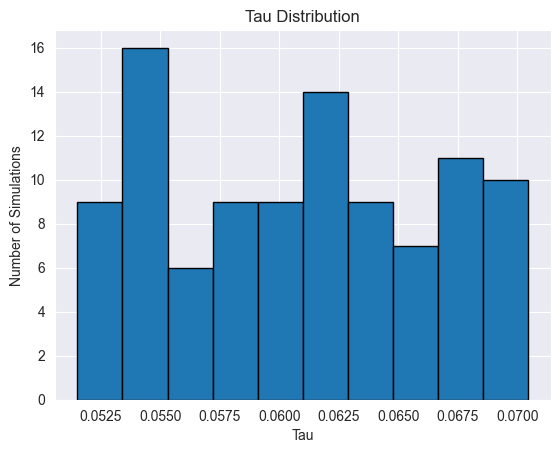

In [196]:
plt.figure()
df["tau"].hist(bins=10, edgecolor="black")
plt.title("Tau Distribution")
plt.xlabel("Tau")
plt.ylabel("Number of Simulations")
plt.show()


### Tau vs Parameter Scatter Plots

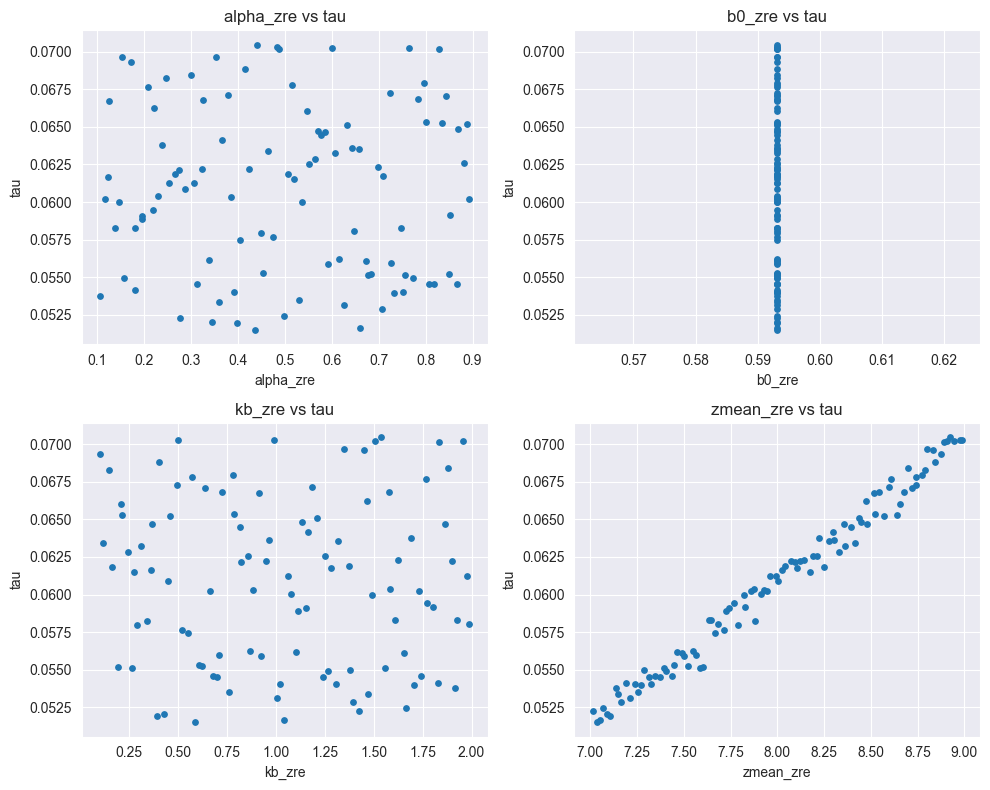

In [197]:
param_cols = ["alpha_zre", "b0_zre", "kb_zre", "zmean_zre"]
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, p in enumerate(param_cols):
    axes[i].scatter(df[p], df["tau"], s=15)
    axes[i].set_xlabel(p)
    axes[i].set_ylabel("tau")
    axes[i].set_title(f"{p} vs tau")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### Spearman Correlation with Tau
- +1.0 : Perfect increasing monotonic relation
- -1.0 : Perfect decreasing relation
-  0.0 : No Monotonic relation

In [198]:
df[param_cols + ["tau"]].corr(method="spearman")["tau"].sort_values(ascending=False)

tau          1.000000
zmean_zre    0.992895
alpha_zre   -0.010309
kb_zre      -0.056322
b0_zre            NaN
Name: tau, dtype: float64

### Angular Power Spectrum
- `ell`: The angular frequency
- `cl_ksz`: The raw angular power spectrum in uK^2 (variance per angular scale)
- `dcl`: Basic uncertainty per bin
- `dcl_ksz`: The rescaled spectrum

In [199]:
ell = h5f[f"sims/sim0/cl/ell"][()]
cl_ksz = h5f[f"sims/sim0/cl/cl_ksz"][()]
dcl = h5f[f"sims/sim0/cl/dcl"][()]
Dl  = h5f[f"sims/sim0/cl/dl_ksz"][()]
print(f"ell:\n{ell}")
print(f"cl_ksz:\n{cl_ksz}")
print(f"dcl:\n{dcl}")
print(f"Dl:\n{Dl}")

ell:
[  135.01857721   360.85979802   586.70101882   812.54223962
  1038.38346043  1264.22468123  1490.06590203  1715.90712284
  1941.74834364  2167.58956445  2393.43078525  2619.27200605
  2845.11322686  3070.95444766  3296.79566846  3522.63688927
  3748.47811007  3974.31933088  4200.16055168  4426.00177248
  4651.84299329  4877.68421409  5103.52543489  5329.3666557
  5555.2078765   5781.04909731  6006.89031811  6232.73153891
  6458.57275972  6684.41398052  6910.25520132  7136.09642213
  7361.93764293  7587.77886374  7813.62008454  8039.46130534
  8265.30252615  8491.14374695  8716.98496775  8942.82618856
  9168.66740936  9394.50863016  9620.34985097  9846.19107177
 10072.03229258 10297.87351338 10523.71473418 10749.55595499
 10975.39717579 11201.23839659]
cl_ksz:
[4.47043444e-03 5.92191370e-05 2.00583913e-05 1.22214567e-05
 7.91759233e-06 5.53313016e-06 4.49606346e-06 3.53853663e-06
 2.73478720e-06 2.31114542e-06 1.86844353e-06 1.58060733e-06
 1.33243517e-06 1.13290608e-06 9.57782188

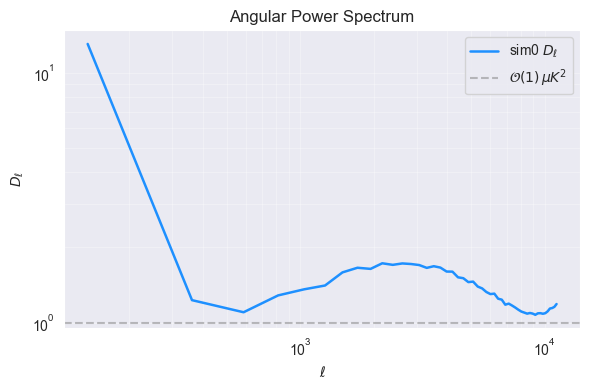

In [200]:
plt.figure(figsize=(6,4))
plt.loglog(ell, Dl, color="dodgerblue", lw=1.8, label=fr"sim0 $D_\ell$")
plt.axhline(1, ls="--", color="gray", alpha=0.5, label=r"$\mathcal{O}(1)\,\mu K^2$")
plt.xlabel(r"$\ell$")
plt.ylabel(r"$D_\ell$")
plt.title("Angular Power Spectrum")
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## Close Files

In [201]:
h5f.close()